This is the second assignment for the Coursera course "Advanced Machine Learning and Signal Processing"


Just execute all cells one after the other and you are done - just note that in the last one you have to update your email address (the one you've used for coursera) and obtain a submission token, you get this from the programming assignment directly on coursera.

Please fill in the sections labelled with "###YOUR_CODE_GOES_HERE###"

In [1]:
!wget https://github.com/IBM/coursera/raw/master/coursera_ml/a2.parquet

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190705203505-0000
KERNEL_ID = 570fdeba-337e-4692-b50b-7ea43abe6cec
--2019-07-05 20:35:08--  https://github.com/IBM/coursera/raw/master/coursera_ml/a2.parquet
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/coursera/master/coursera_ml/a2.parquet [following]
--2019-07-05 20:35:08--  https://raw.githubusercontent.com/IBM/coursera/master/coursera_ml/a2.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59032 (58K) [application/octet-stream]
Saving to: 'a2.parquet'

a2.parquet          100%[===================>]  57.65K  --.-KB/s    in 0.002s  

Now it’s time to have a look at the recorded sensor data. You should see data similar to the one exemplified below….


In [2]:
df=spark.read.load('a2.parquet')

df.createOrReplaceTempView("df")
spark.sql("SELECT * from df").show()


+-----+-----------+-------------------+-------------------+-------------------+
|CLASS|   SENSORID|                  X|                  Y|                  Z|
+-----+-----------+-------------------+-------------------+-------------------+
|    0|         26| 380.66434005495194| -139.3470983812975|-247.93697521077704|
|    0|         29| 104.74324299209692| -32.27421440203938|-25.105013725863852|
|    0| 8589934658| 118.11469236129976| 45.916682927433534| -87.97203782706572|
|    0|34359738398| 246.55394030642543|-0.6122810693132044|-398.18662513951506|
|    0|17179869241|-190.32584900181487|  234.7849657520335|-206.34483804019288|
|    0|25769803830| 178.62396382387422| -47.07529438881511|  84.38310769821979|
|    0|25769803831|  85.03128805189493|-4.3024316644854546|-1.1841857567516714|
|    0|34359738411| 26.786262674736566| -46.33193951911338| 20.880756008396055|
|    0| 8589934592|-16.203752396859194| 51.080957032176954| -96.80526656416971|
|    0|25769803852|   47.2048142440404| 

In [3]:
spark.sql("SELECT CLASS, COUNT(CLASS) from df GROUP BY CLASS").show()

+-----+------------+
|CLASS|count(CLASS)|
+-----+------------+
|    1|        1416|
|    0|        1626|
+-----+------------+



Please create a VectorAssembler which consumes columns X, Y and Z and produces a column “features”


In [4]:
from pyspark.ml.feature import VectorAssembler
df = df.withColumnRenamed('CLASS','label')
vectorAssembler = VectorAssembler(inputCols=['X','Y','Z'], outputCol='features')###YOUR_CODE_GOES_HERE###"

Please instantiate a classifier from the SparkML package and assign it to the classifier variable. Make sure to either
1.	Rename the “CLASS” column to “label” or
2.	Specify the label-column correctly to be “CLASS”


In [5]:
from pyspark.ml.classification import GBTClassifier ###YOUR_CODE_GOES_HERE###"
from pyspark.ml.feature import Normalizer

classifier = GBTClassifier(featuresCol='features', labelCol='label', maxIter=100)
#LinearSVC(maxIter=30,regParam=0.01,featuresCol='features')###YOUR_CODE_GOES_HERE###"
normalizer = Normalizer(inputCol='features',outputCol='features_norm', p=1.0)


from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler,normalizer,classifier])
trans_pipeline = Pipeline(stages=[vectorAssembler,normalizer])
model = pipeline.fit(df)
trans_model = trans_pipeline.fit(df)


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def extract(row):
    return (row.label, ) + tuple(row.features_norm.toArray().tolist())



#Enable interactive
%matplotlib notebook

#Collect to plot
df_out = trans_model.transform(df)
df_plot = df_out.rdd.map(extract).toDF().select('*').toPandas()
for prev,new in zip(df_plot.columns, ['CLASS','X','Y','Z']):
    df_plot.rename(columns={prev:new}, inplace=True)

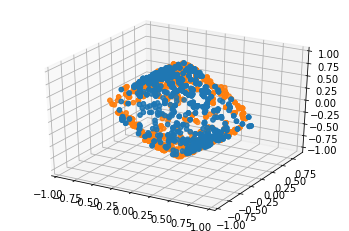

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for co in df_plot.CLASS.unique():
    df_plot_class = df_plot.loc[df_plot.CLASS == co]
    ax.scatter(df_plot_class.X, df_plot_class.Y, df_plot_class.Z)

In [8]:
prediction = model.transform(df)

In [9]:
prediction.createOrReplaceTempView('prediction_table')
spark.sql('SELECT DISTINCT prediction from prediction_table').show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [10]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")

    
binEval.evaluate(prediction) 

1.0

In [25]:
#Rename label col to CLASS for Coursera grader
prediction = prediction.withColumnRenamed('label','CLASS')

If you are happy with the result (I’m happy with > 0.55) please submit your solution to the grader by executing the following cells, please don’t forget to obtain an assignment submission token (secret) from the Coursera’s graders web page and paste it to the “secret” variable below, including your email address you’ve used for Coursera. (0.55 means that you are performing better than random guesses)


In [26]:
!rm -Rf a2_m2.json

In [27]:
prediction = prediction.repartition(1)
prediction.write.json('a2_m2.json')

In [28]:
!rm -f rklib.py
!wget https://raw.githubusercontent.com/IBM/coursera/master/rklib.py

--2019-07-05 20:57:10--  https://raw.githubusercontent.com/IBM/coursera/master/rklib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540 (2.5K) [text/plain]
Saving to: 'rklib.py'

rklib.py            100%[===================>]   2.48K  --.-KB/s    in 0s      

2019-07-05 20:57:10 (64.6 MB/s) - 'rklib.py' saved [2540/2540]



In [29]:
import zipfile

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('a2_m2.json.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('a2_m2.json', zipf)
zipf.close()

In [30]:
!base64 a2_m2.json.zip > a2_m2.json.zip.base64

In [31]:
from rklib import submit
key = "J3sDL2J8EeiaXhILFWw2-g"
part = "G4P6f"
email = "dustin.brown.andrews@gmail.com"###YOUR_CODE_GOES_HERE###"
secret = "UW65VoOhSo3eOshP"###YOUR_CODE_GOES_HERE###"

with open('a2_m2.json.zip.base64', 'r') as myfile:
    data=myfile.read()
submit(email, secret, key, part, [part], data)

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"LTL4F","id":"f_F-qCtuEei_fRLwaVDk3g~LTL4F~deTXSZ9nEemsLA5tu4oyQg","courseId":"f_F-qCtuEei_fRLwaVDk3g"}],"paging":{},"linked":{}}
-------------------------
